# Image Classification of ATLAS Calorimeter Topo-Clusters

This notebook includes performance comparisons of different Machine Learning techniques for classifying topological clusters in the ATLAS calorimeter. 

### The task

Train a classifier to determine which type of particle generated the parton showers in the cluster (e.g. $e^{\pm}$ vs. $\pi^{\pm}$ or $\pi^0$ vs. $\pi^{\pm}$).

### The cluster images

Each cluster is associated with six 2D images, corresponding to the barrels layers of the EM (EMB1, EMB2, EMB3) and HAD (TileBar0, TileBar2, TileBar3) calorimeters. Normalized calorimeter cell energies are used as pixel values. The image size is $0.4\times0.4$ in $\eta\times\phi$ space.

The following models are implemented:

1. Simple fully-connected Neural Network (flattening the images and only using the 512 pixels in the EMB1 layer).
2. Convolutional Neural Networks using only one layer (preserving the shape of the 2D images).
3. A network with multiple images as inputs, and one output (first couple of ConvNets are trained separately, then flattened and concatenated). 

TODO
- Cleanup code a bit, in particular make it easier to swap samples.
- Probably modify inputs to be just numpy arrays (rather than a dictionary of arrays), makes it easier to slice and dice inputs. 
- Implement a network of concatenated ConvNets taking all calorimeter layer images into account.
- Also compare the performance with other ML algorithms; logistic regression, SVD, Naive Bias, Gaussians, etc.


In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]

## Import the datasets 

The notebook is structured to make the swapping of datasets trivial. 

In [ ]:
# import electron vs. pion images (pt = 100 GeV)

elec = np.load("../datasets/images_electron_100_v01-4-g1135c42.npz")
pion = np.load("../datasets/images_pion_100_v01-4-g1135c42.npz")

nelec = len(elec['EMB1'])
npion = len(pion['EMB1'])
print("Number of electron events: {}".format(nelec))
print("Number of pion events: {}".format(npion))
print("Total: {}".format(nelec+npion))

In [2]:
# import pi+- vs. pi0 images

# seed = 10
# np.random.seed(seed)

nmax = 50000
# TODO fix input files so that it is easier to split up the events
p0 = np.load("/eos/user/m/mswiatlo/images/pi0_small.npz")
pp = np.load("/eos/user/m/mswiatlo/images/piplus_small.npz")
pm = np.load("/eos/user/m/mswiatlo/images/piminus_small.npz")

# pc = {}
#concat pp and pm for greater stats
# pc = {key:np.append(pp[key], pm[key], 0) for key in pp}

np0 = len(p0['EMB1'])
npp = len(pp['EMB1'])
npm = len(pm['EMB1'])
# npc = len(pc['EMB1'])


print("Number of pi0 events: {}".format(np0))
print("Number of pi+ events: {}".format(npp))
print("Number of pi- events: {}".format(npm))
# print("Number of cpi events: {}".format(npc))
print("Total: {}".format(np0+npp+npm))

# print pp['label']
# print pm['label']
# print p0['label']

Number of pi0 events: 50000
Number of pi+ events: 50000
Number of pi- events: 50000
Total: 150000


In [80]:
# print type(dict(p0))
# print dict(p0)
print pp['label']
p0_100 = {highE for highE in p0 if highE['clusterE'] > 100}
#p0['clusterE'] > 100

[[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]


TypeError: string indices must be integers, not str

### Plot a few example images

In [ ]:
# plots for pT = 100 GeV electron/pion samples

from matplotlib.colors import Normalize, LogNorm

# specify which cluster to plot
cluster = 10

# make the plot
plt.cla(); plt.clf()
fig = plt.figure(figsize=(10,30))
fig.patch.set_facecolor('white')


i = 1
for layer in layers:
    
    # electrons
    plt.subplot(6,2,i)
    i += 1
    plt.imshow(elec[layer][cluster], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest', norm=Normalize(vmin=0.0001, vmax=0.01))
    plt.colorbar()
    plt.title('Electrons in {}'.format(layer))
    plt.xlabel("$\Delta\phi$")
    plt.ylabel("$\Delta\eta$")
    
    # all(?) pions
    plt.subplot(6,2,i)
    i += 1
    plt.imshow(pion[layer][cluster], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest', norm=Normalize(vmin=0.0001, vmax=0.01))
    plt.colorbar()
    plt.title('Pions in {}'.format(layer))
    plt.xlabel("$\Delta\phi$")
    plt.ylabel("$\Delta\eta$")

# show the plots
plt.show()
#plt.savefig('plots_pion_electron.pdf')

<Figure size 432x288 with 0 Axes>

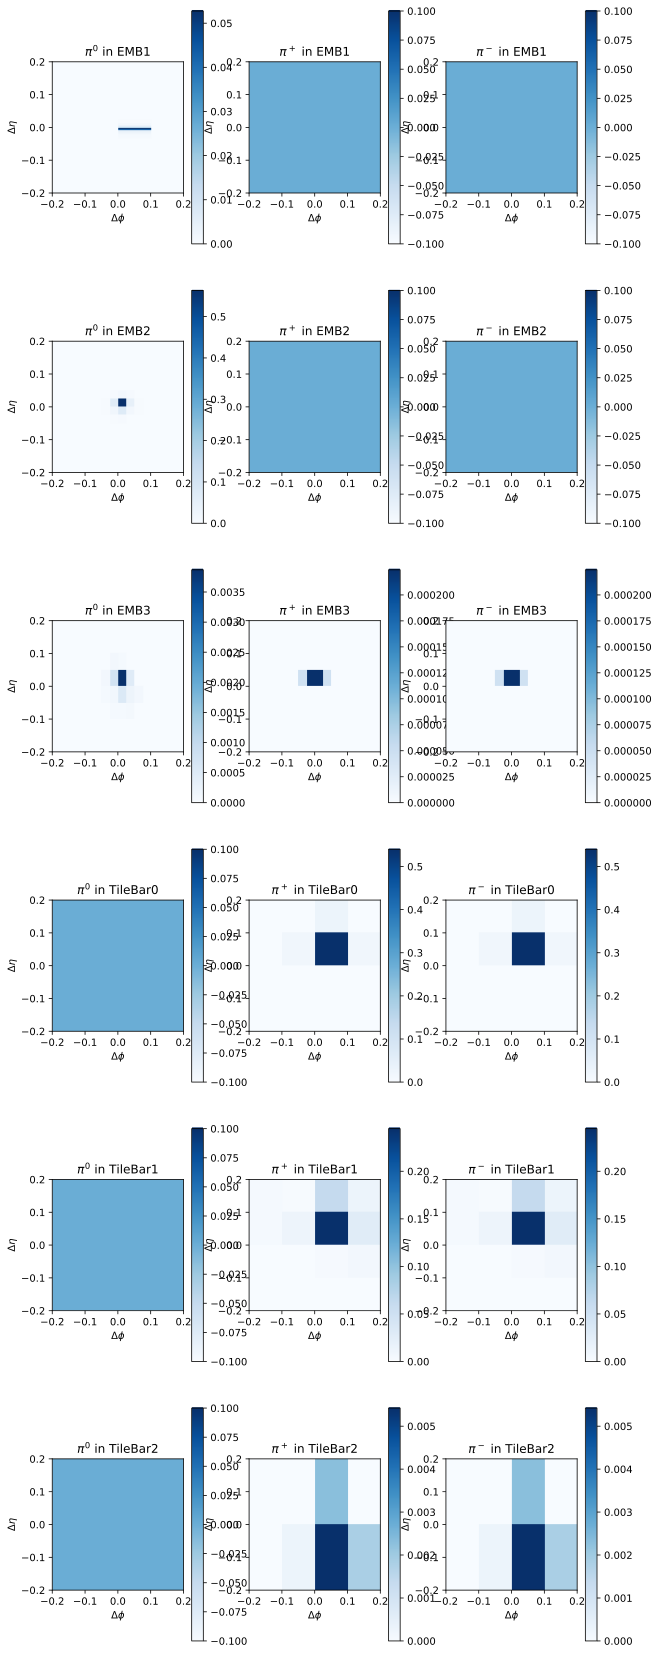

In [85]:
# plots for E = 0.5-2000 GeV pi0/pi+/pi- samples

from matplotlib.colors import Normalize, LogNorm

# specify which cluster to plot
cluster = 1005

# make the plot
plt.cla(); plt.clf()
fig = plt.figure(figsize=(10,30))
fig.patch.set_facecolor('white')

i = 1
for layer in layers:
    
    # pi0
    plt.subplot(6,3,i)
    i += 1
    plt.imshow(p0[layer][cluster], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest')
    plt.colorbar()
    plt.title('$\pi^0$ in {}'.format(layer))
    plt.xlabel("$\Delta\phi$")
    plt.ylabel("$\Delta\eta$")

    # pi+
    plt.subplot(6,3,i)
    i += 1
    plt.imshow(pp[layer][cluster], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest')
    plt.colorbar()
    plt.title('$\pi^+$ in {}'.format(layer))
    plt.xlabel("$\Delta\phi$")
    plt.ylabel("$\Delta\eta$")
    
    # pi-
    plt.subplot(6,3,i)
    i += 1
    plt.imshow(pm[layer][cluster], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest')
    plt.colorbar()
    plt.title('$\pi^-$ in {}'.format(layer))
    plt.xlabel("$\Delta\phi$")
    plt.ylabel("$\Delta\eta$")

# show the plots
plt.show()
#plt.savefig('plots_pi0_plus_minus.pdf')

### Plot a few histograms

NameError: name 'pion' is not defined

<Figure size 432x288 with 0 Axes>

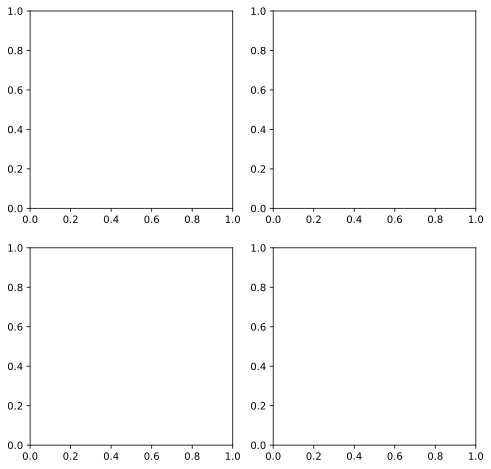

In [86]:
# histograms for pT = 100 GeV electron/pion samples

n_bins=30

plt.cla(); plt.clf()
fig, ax = plt.subplots(2, 2, figsize=(8,8))
fig.patch.set_facecolor('white')

# number of cells per cluster
ax[0,0].hist(pion['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='Pions')
ax[0,0].hist(elec['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='Electrons')
ax[0,0].set_xlabel('Cells/Cluster')
ax[0,0].legend()

# cluster energy
ax[0,1].hist(pion['clusterE'], bins=n_bins, normed=True, range=(50,150), alpha=0.7, label='Pions')
ax[0,1].hist(elec['clusterE'], bins=n_bins, normed=True, range=(50,150), alpha=0.7, label='Electrons')
ax[0,1].set_xlabel('Cluster Energy [GeV]')
ax[0,1].legend()

# cluster pseudo-rapidity, eta = -ln(tan(theta/2))
ax[1,0].hist(pion['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='Pions')
ax[1,0].hist(elec['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='Electrons')
ax[1,0].set_xlabel('Cluster $\eta$')
ax[1,0].legend()

# cluster azimuthal angle 
ax[1,1].hist(pion['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='Pions')
ax[1,1].hist(elec['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='Electrons')
ax[1,1].set_xlabel('Cluster $\phi$')
ax[1,1].legend()

plt.show()
#plt.savefig('hist_pion_electron.pdf')

/cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 432x288 with 0 Axes>

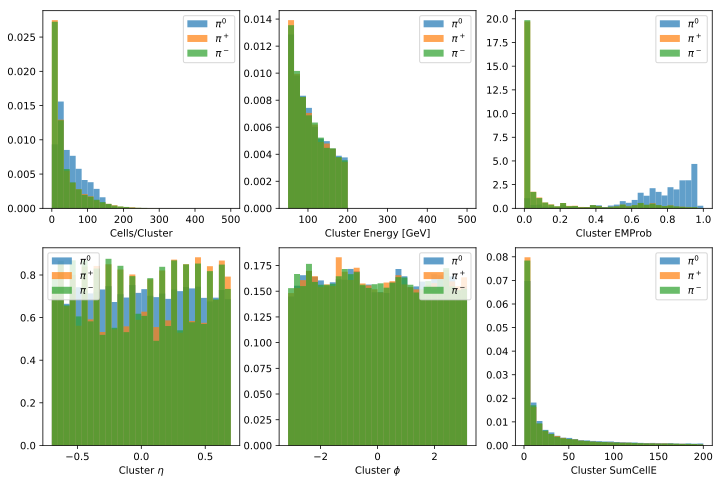

In [3]:
# histograms for E = 0.5-2000 GeV pi0/pi+/pi- samples

n_bins=30

plt.cla(); plt.clf()
fig, ax = plt.subplots(2, 3, figsize=(12,8))
fig.patch.set_facecolor('white')

# number of cells per cluster
ax[0,0].hist(p0['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='$\pi^0$')
ax[0,0].hist(pp['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='$\pi^+$')
ax[0,0].hist(pm['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='$\pi^-$')
# ax[0,0].hist(pc['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='$\pi^{\pm}$')
ax[0,0].set_xlabel('Cells/Cluster')
ax[0,0].legend()

# cluster energy
ax[0,1].hist(p0['clusterE'], bins=n_bins, normed=True, range=(50,500), alpha=0.7, label='$\pi^0$')
ax[0,1].hist(pp['clusterE'], bins=n_bins, normed=True, range=(50,500), alpha=0.7, label='$\pi^+$')
ax[0,1].hist(pm['clusterE'], bins=n_bins, normed=True, range=(50,500), alpha=0.7, label='$\pi^-$')
# ax[0,1].hist(pc['clusterE'], bins=n_bins, normed=True, range=(50,500), alpha=0.7, label='$\pi^{\pm}$')
ax[0,1].set_xlabel('Cluster Energy [GeV]')
ax[0,1].legend()

# cluster pseudo-rapidity, eta = -ln(tan(theta/2))
ax[1,0].hist(p0['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
ax[1,0].hist(pp['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
ax[1,0].hist(pm['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^-$')
# ax[1,0].hist(pc['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^{\pm}$')
ax[1,0].set_xlabel('Cluster $\eta$')
ax[1,0].legend()

# cluster azimuthal angle 
ax[1,1].hist(p0['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
ax[1,1].hist(pp['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
ax[1,1].hist(pm['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^-$')
# ax[1,1].hist(pc['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^{\pm}$')
ax[1,1].set_xlabel('Cluster $\phi$')
ax[1,1].legend()

# cluster EM prob
ax[0,2].hist(p0['cluster_emProb'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
ax[0,2].hist(pp['cluster_emProb'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
ax[0,2].hist(pm['cluster_emProb'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^-$')
# ax[1,1].hist(pc['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^{\pm}$')
ax[0,2].set_xlabel('Cluster EMProb')
ax[0,2].legend()

# cluster sum cell e
ax[1,2].hist(p0['cluster_sumCellE'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
ax[1,2].hist(pp['cluster_sumCellE'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
ax[1,2].hist(pm['cluster_sumCellE'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^-$')
# ax[1,1].hist(pc['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^{\pm}$')
ax[1,2].set_xlabel('Cluster SumCellE')
ax[1,2].legend()

plt.show()
#plt.savefig('hist_pi0_plus_minus.pdf')

## 1. Simple feed-forward Neural Network

In [ ]:
# Train on pT = 100 GeV electron/pion samples

# only include the EMB1 layer, flattened
# layer = layers[0]
# num_pixels = int(len_phi[0]*len_eta[0])

# X = np.append(elec[layer].reshape((len(elec[layer]),num_pixels)),
#               pion[layer].reshape((len(pion[layer]),num_pixels)), axis=0)

# y = np.append(elec['label'], pion['label'], axis=0)

# print (X.shape)
# print (y.shape)

In [4]:
# # Train on E = 0.5-2000 GeV pi0/pi+/pi- samples

# # only include the EMB2 layer, flattened, to compare better to results below
def format_flat(data_0, data_1, selected_layer, len_phi = len_phi, len_eta = len_eta):
    layer = layers[selected_layer]
    num_pixels = int(len_phi[selected_layer]*len_eta[selected_layer])

    X = np.append(data_0[layer].reshape((len(data_0[layer]),num_pixels)),
                  data_1[layer].reshape((len(data_1[layer]),num_pixels)), axis=0)

    y = np.append(data_0['label'], data_1['label'], axis=0)

    print (X.shape)
    print (y.shape)
    return X, y, num_pixels

In [5]:
x_flat = {}
y_flat = {}
num_pixels_flat = {}
for layer_i, layer_name in enumerate(layers):
    x_flat[layer_i], y_flat[layer_i], num_pixels_flat[layer_i] = format_flat(p0, pp, layer_i)

(100000, 512)
(100000, 1)
(100000, 256)
(100000, 1)
(100000, 128)
(100000, 1)
(100000, 16)
(100000, 1)
(100000, 16)
(100000, 1)
(100000, 8)
(100000, 1)


In [ ]:
print num_pixels_flat

In [ ]:
# split up into training and test datasets
# Old, hard-coded
test_size = 4000
validation_size = 1000
from sklearn.model_selection import train_test_split
X_tr, X_te_vl, y_tr, y_te_vl, = train_test_split(X, y, test_size=test_size+validation_size, random_state=1)
X_te, X_vl, y_te, y_vl, = train_test_split(X_te_vl, y_te_vl, test_size=validation_size, random_state=1)

# normalize inputs from 0-255 to 0-1
X_tr = X_tr / 255
X_te = X_te / 255
X_vl = X_vl / 255

# one hot encode outputs
from keras.utils import np_utils
y_tr_onehot = np_utils.to_categorical(y_tr, 2)
y_te_onehot = np_utils.to_categorical(y_te, 2)
y_vl_onehot = np_utils.to_categorical(y_vl, 2)
num_classes = y_te_onehot.shape[1]
print("y_train.shape: ",y_tr.shape)
print("y_train_onehot.shape: ",y_tr_onehot.shape)

In [6]:
#now as a function

test_size = 20000
validation_size = 5000
from sklearn.model_selection import train_test_split
def make_split_samples(X, y, test_size, validation_size):
    X_tr, X_te_vl, y_tr, y_te_vl, = train_test_split(X, y, test_size=test_size+validation_size, random_state=1)
    X_te, X_vl, y_te, y_vl, = train_test_split(X_te_vl, y_te_vl, test_size=validation_size, random_state=1)

    # normalize inputs from 0-255 to 0-1
    # this seems to be done already??
#     X_tr = X_tr / 255
#     X_te = X_te / 255
#     X_vl = X_vl / 255

    # one hot encode outputs
    from keras.utils import np_utils
    y_tr_onehot = np_utils.to_categorical(y_tr, 2)
    y_te_onehot = np_utils.to_categorical(y_te, 2)
    y_vl_onehot = np_utils.to_categorical(y_vl, 2)
    num_classes = y_te_onehot.shape[1]
    print("y_train.shape: ",y_tr.shape)
    print("y_train_onehot.shape: ",y_tr_onehot.shape)
    
    return X_tr, X_te, X_vl, y_tr_onehot, y_te_onehot, y_vl_onehot

In [10]:
x_flat_tr = {}
x_flat_te = {}
x_flat_vl = {}
y_flat_tr_onehot = {}
y_flat_te_onehot = {}
y_flat_vl_onehot = {}
for layer_i, layer_name in enumerate(layers):
    x_flat_tr[layer_i], x_flat_te[layer_i], x_flat_vl[layer_i], y_flat_tr_onehot[layer_i], y_flat_te_onehot[layer_i], y_flat_vl_onehot[layer_i] = make_split_samples(x_flat[layer_i], y_flat[layer_i], test_size, validation_size)

('y_train.shape: ', (75000, 1))
('y_train_onehot.shape: ', (75000, 2))
('y_train.shape: ', (75000, 1))
('y_train_onehot.shape: ', (75000, 2))
('y_train.shape: ', (75000, 1))
('y_train_onehot.shape: ', (75000, 2))
('y_train.shape: ', (75000, 1))
('y_train_onehot.shape: ', (75000, 2))
('y_train.shape: ', (75000, 1))
('y_train_onehot.shape: ', (75000, 2))
('y_train.shape: ', (75000, 1))
('y_train_onehot.shape: ', (75000, 2))


In [19]:
print y_flat_tr_onehot[0]

[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [7]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense

# define baseline fully-connected NN model
def baseline_nn_model(number_pixels):
    # create model
    model = Sequential()
    used_pixels = number_pixels
#     if number_pixels < 128:
#         used_pixels = 128
    model.add(Dense(number_pixels, input_dim=number_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(used_pixels, activation='relu'))
    model.add(Dense(used_pixels/2, activation='relu'))
    model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
    # compile model
    optimizer = Adam(lr=5e-5)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

Using TensorFlow backend.


In [8]:
# build the model
models_flat = {}
for layer_i, layer_name in enumerate(layers):
    models_flat[layer_i] = baseline_nn_model(num_pixels_flat[layer_i])
    models_flat[layer_i].summary()

W1127 14:11:53.975918 140507517916992 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1127 14:11:54.012110 140507517916992 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1127 14:11:54.018352 140507517916992 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W1127 14:11:54.044274 140507517916992 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/pyth

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 514       
Total params: 657,154
Trainable params: 657,154
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dens

In [61]:
# fit (train) the model, old way directly
history = model_nn.fit(X_tr, y_tr_onehot, validation_data=(X_vl, y_vl_onehot), epochs=50, batch_size=200, verbose=2)

# final evaluation of the model
scores = model_nn.evaluate(X_te, y_te_onehot, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

NameError: name 'model_nn' is not defined

In [11]:
from keras.callbacks import EarlyStopping

# now automated with functions
history_flat = {}
scores = {}
# es = EarlyStopping(monitor='val_acc', mode='max')
for layer_i, layer_name in enumerate(layers):
    print 'On layer {}'.format(layer_name)
    history_flat[layer_i] = models_flat[layer_i].fit(x_flat_tr[layer_i], y_flat_tr_onehot[layer_i], validation_data=(x_flat_vl[layer_i], y_flat_vl_onehot[layer_i]), epochs = 60, batch_size = 200, verbose = 2)
    scores[layer_i] = models_flat[layer_i].evaluate(x_flat_te[layer_i], y_flat_te_onehot[layer_i], verbose = 0)
    print("Layer {} Baseline Error: {}".format(layer_name, 100-scores[layer_i][1]*100))

W1127 14:12:59.670443 140507517916992 deprecation.py:323] From /cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/tensorflow/python/ops/math_grad.py:1250: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


On layer EMB1
Train on 75000 samples, validate on 5000 samples
Epoch 1/60
 - 14s - loss: 0.5601 - acc: 0.8117 - val_loss: 0.4238 - val_acc: 0.8400
Epoch 2/60
 - 14s - loss: 0.4107 - acc: 0.8428 - val_loss: 0.3932 - val_acc: 0.8526
Epoch 3/60
 - 14s - loss: 0.3970 - acc: 0.8457 - val_loss: 0.3846 - val_acc: 0.8544
Epoch 4/60
 - 14s - loss: 0.3917 - acc: 0.8485 - val_loss: 0.3803 - val_acc: 0.8554
Epoch 5/60
 - 13s - loss: 0.3882 - acc: 0.8502 - val_loss: 0.3753 - val_acc: 0.8570
Epoch 6/60
 - 14s - loss: 0.3851 - acc: 0.8521 - val_loss: 0.3721 - val_acc: 0.8580
Epoch 7/60
 - 14s - loss: 0.3821 - acc: 0.8532 - val_loss: 0.3686 - val_acc: 0.8614
Epoch 8/60
 - 14s - loss: 0.3792 - acc: 0.8551 - val_loss: 0.3653 - val_acc: 0.8610
Epoch 9/60
 - 13s - loss: 0.3769 - acc: 0.8561 - val_loss: 0.3644 - val_acc: 0.8632
Epoch 10/60
 - 12s - loss: 0.3746 - acc: 0.8576 - val_loss: 0.3615 - val_acc: 0.8668
Epoch 11/60
 - 13s - loss: 0.3727 - acc: 0.8587 - val_loss: 0.3597 - val_acc: 0.8670
Epoch 12/60

 - 5s - loss: 0.3511 - acc: 0.8584 - val_loss: 0.3487 - val_acc: 0.8640
Epoch 37/60
 - 5s - loss: 0.3493 - acc: 0.8595 - val_loss: 0.3466 - val_acc: 0.8638
Epoch 38/60
 - 5s - loss: 0.3479 - acc: 0.8593 - val_loss: 0.3447 - val_acc: 0.8670
Epoch 39/60
 - 5s - loss: 0.3459 - acc: 0.8607 - val_loss: 0.3426 - val_acc: 0.8658
Epoch 40/60
 - 6s - loss: 0.3445 - acc: 0.8608 - val_loss: 0.3428 - val_acc: 0.8688
Epoch 41/60
 - 5s - loss: 0.3433 - acc: 0.8612 - val_loss: 0.3417 - val_acc: 0.8624
Epoch 42/60
 - 5s - loss: 0.3415 - acc: 0.8614 - val_loss: 0.3387 - val_acc: 0.8660
Epoch 43/60
 - 5s - loss: 0.3402 - acc: 0.8628 - val_loss: 0.3377 - val_acc: 0.8660
Epoch 44/60
 - 5s - loss: 0.3390 - acc: 0.8630 - val_loss: 0.3372 - val_acc: 0.8686
Epoch 45/60
 - 4s - loss: 0.3377 - acc: 0.8636 - val_loss: 0.3352 - val_acc: 0.8680
Epoch 46/60
 - 5s - loss: 0.3362 - acc: 0.8639 - val_loss: 0.3369 - val_acc: 0.8654
Epoch 47/60
 - 5s - loss: 0.3350 - acc: 0.8642 - val_loss: 0.3346 - val_acc: 0.8702
Epoc

Epoch 12/60
 - 1s - loss: 0.5654 - acc: 0.7118 - val_loss: 0.5643 - val_acc: 0.7166
Epoch 13/60
 - 1s - loss: 0.5645 - acc: 0.7130 - val_loss: 0.5635 - val_acc: 0.7156
Epoch 14/60
 - 1s - loss: 0.5637 - acc: 0.7135 - val_loss: 0.5628 - val_acc: 0.7182
Epoch 15/60
 - 1s - loss: 0.5631 - acc: 0.7142 - val_loss: 0.5620 - val_acc: 0.7182
Epoch 16/60
 - 1s - loss: 0.5624 - acc: 0.7148 - val_loss: 0.5614 - val_acc: 0.7188
Epoch 17/60
 - 1s - loss: 0.5618 - acc: 0.7156 - val_loss: 0.5607 - val_acc: 0.7194
Epoch 18/60
 - 1s - loss: 0.5612 - acc: 0.7165 - val_loss: 0.5601 - val_acc: 0.7198
Epoch 19/60
 - 1s - loss: 0.5606 - acc: 0.7171 - val_loss: 0.5595 - val_acc: 0.7204
Epoch 20/60
 - 1s - loss: 0.5600 - acc: 0.7173 - val_loss: 0.5588 - val_acc: 0.7216
Epoch 21/60
 - 1s - loss: 0.5594 - acc: 0.7181 - val_loss: 0.5582 - val_acc: 0.7218
Epoch 22/60
 - 1s - loss: 0.5589 - acc: 0.7187 - val_loss: 0.5576 - val_acc: 0.7218
Epoch 23/60
 - 1s - loss: 0.5583 - acc: 0.7192 - val_loss: 0.5571 - val_acc:

Epoch 49/60
 - 1s - loss: 0.5337 - acc: 0.7167 - val_loss: 0.5332 - val_acc: 0.7150
Epoch 50/60
 - 1s - loss: 0.5334 - acc: 0.7168 - val_loss: 0.5328 - val_acc: 0.7154
Epoch 51/60
 - 1s - loss: 0.5330 - acc: 0.7170 - val_loss: 0.5326 - val_acc: 0.7150
Epoch 52/60
 - 1s - loss: 0.5326 - acc: 0.7173 - val_loss: 0.5323 - val_acc: 0.7166
Epoch 53/60
 - 1s - loss: 0.5323 - acc: 0.7173 - val_loss: 0.5318 - val_acc: 0.7166
Epoch 54/60
 - 1s - loss: 0.5320 - acc: 0.7176 - val_loss: 0.5315 - val_acc: 0.7166
Epoch 55/60
 - 1s - loss: 0.5317 - acc: 0.7176 - val_loss: 0.5311 - val_acc: 0.7168
Epoch 56/60
 - 1s - loss: 0.5314 - acc: 0.7179 - val_loss: 0.5308 - val_acc: 0.7168
Epoch 57/60
 - 1s - loss: 0.5310 - acc: 0.7180 - val_loss: 0.5306 - val_acc: 0.7174
Epoch 58/60
 - 1s - loss: 0.5307 - acc: 0.7182 - val_loss: 0.5302 - val_acc: 0.7172
Epoch 59/60
 - 1s - loss: 0.5304 - acc: 0.7183 - val_loss: 0.5299 - val_acc: 0.7174
Epoch 60/60
 - 1s - loss: 0.5301 - acc: 0.7186 - val_loss: 0.5296 - val_acc:

In [56]:
print np.max(x_flat_tr[1]) * 255

0.9919576644897461


In [42]:
#EMB2 should be doing better... give it some more epochs, and slightly faster learning rate (5e-5 set now, was 1e-5 for the above training)

layer_i = 1
models_flat[layer_i] =  baseline_nn_model(num_pixels_flat[layer_i])
history_flat[layer_i] = models_flat[layer_i].fit(x_flat_tr[layer_i], y_flat_tr_onehot[layer_i], validation_data=(x_flat_vl[layer_i], y_flat_vl_onehot[layer_i]), epochs = 60, batch_size = 200, verbose = 2)
scores[layer_i] = models_flat[layer_i].evaluate(x_flat_te[layer_i], y_flat_te_onehot[layer_i], verbose = 0)

Train on 75000 samples, validate on 5000 samples
Epoch 1/60
 - 8s - loss: 0.6931 - acc: 0.5043 - val_loss: 0.6931 - val_acc: 0.4964
Epoch 2/60
 - 6s - loss: 0.6931 - acc: 0.5160 - val_loss: 0.6930 - val_acc: 0.5036
Epoch 3/60
 - 6s - loss: 0.6929 - acc: 0.5249 - val_loss: 0.6926 - val_acc: 0.6408
Epoch 4/60
 - 6s - loss: 0.6920 - acc: 0.5490 - val_loss: 0.6908 - val_acc: 0.5470
Epoch 5/60
 - 6s - loss: 0.6882 - acc: 0.6174 - val_loss: 0.6832 - val_acc: 0.6936
Epoch 6/60
 - 5s - loss: 0.6758 - acc: 0.6750 - val_loss: 0.6654 - val_acc: 0.6768
Epoch 7/60
 - 5s - loss: 0.6563 - acc: 0.6865 - val_loss: 0.6455 - val_acc: 0.7084
Epoch 8/60
 - 5s - loss: 0.6383 - acc: 0.6850 - val_loss: 0.6284 - val_acc: 0.7032
Epoch 9/60
 - 6s - loss: 0.6253 - acc: 0.6838 - val_loss: 0.6142 - val_acc: 0.6838
Epoch 10/60
 - 6s - loss: 0.6145 - acc: 0.6866 - val_loss: 0.6044 - val_acc: 0.6942
Epoch 11/60
 - 6s - loss: 0.6057 - acc: 0.6897 - val_loss: 0.5996 - val_acc: 0.7106
Epoch 12/60
 - 6s - loss: 0.5975 - a

In [47]:
#EMB3 should be doing better... give it some more epochs, and slightly faster learning rate (5e-5 set now, was 1e-5 for the above training)

layer_i = 2
models_flat[layer_i] =  baseline_nn_model(num_pixels_flat[layer_i])
history_flat[layer_i] = models_flat[layer_i].fit(x_flat_tr[layer_i], y_flat_tr_onehot[layer_i], validation_data=(x_flat_vl[layer_i], y_flat_vl_onehot[layer_i]), epochs = 60, batch_size = 100, verbose = 2)
scores[layer_i] = models_flat[layer_i].evaluate(x_flat_te[layer_i], y_flat_te_onehot[layer_i], verbose = 0)

Train on 75000 samples, validate on 5000 samples
Epoch 1/60
 - 5s - loss: 0.6932 - acc: 0.5022 - val_loss: 0.6931 - val_acc: 0.5036
Epoch 2/60
 - 3s - loss: 0.6931 - acc: 0.5010 - val_loss: 0.6931 - val_acc: 0.5036
Epoch 3/60
 - 3s - loss: 0.6931 - acc: 0.5010 - val_loss: 0.6931 - val_acc: 0.5036
Epoch 4/60
 - 3s - loss: 0.6931 - acc: 0.5010 - val_loss: 0.6931 - val_acc: 0.5036
Epoch 5/60
 - 3s - loss: 0.6931 - acc: 0.5010 - val_loss: 0.6931 - val_acc: 0.5036
Epoch 6/60
 - 3s - loss: 0.6931 - acc: 0.5010 - val_loss: 0.6931 - val_acc: 0.5036
Epoch 7/60
 - 3s - loss: 0.6931 - acc: 0.5010 - val_loss: 0.6931 - val_acc: 0.5036
Epoch 8/60
 - 3s - loss: 0.6931 - acc: 0.5005 - val_loss: 0.6931 - val_acc: 0.5036
Epoch 9/60
 - 3s - loss: 0.6931 - acc: 0.4999 - val_loss: 0.6931 - val_acc: 0.5036
Epoch 10/60
 - 3s - loss: 0.6931 - acc: 0.5010 - val_loss: 0.6931 - val_acc: 0.5036
Epoch 11/60
 - 3s - loss: 0.6931 - acc: 0.5010 - val_loss: 0.6931 - val_acc: 0.5036
Epoch 12/60
 - 3s - loss: 0.6931 - a

In [ ]:
# Plot accuracy and loss vs. epoch

# list all data in history
print(history.history.keys())

plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# plot ROC curve
from sklearn.metrics import roc_curve, auc
y_pred = model_nn.predict(X_te)
fpr_nn, tpr_nn, thres_nn = roc_curve(y_te_onehot[:,0], y_pred[:,0])
auc_nn = auc(fpr_nn, tpr_nn)
print("Area under curve: {}".format(auc_nn))

In [12]:
# roc curves, for all layers

from sklearn.metrics import roc_curve, auc
y_flat_pred = {}
fpr_flat_nn = {} 
tpr_flat_nn = {} 
thres_flat_nn = {}
auc_flat_nn = {}
for layer_i, layer_name in enumerate(layers):
    y_flat_pred[layer_i] = models_flat[layer_i].predict(x_flat_te[layer_i])
    fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], thres_flat_nn[layer_i] = roc_curve(y_flat_te_onehot[layer_i][:,0], y_flat_pred[layer_i][:,0])
    auc_flat_nn[layer_i] = auc(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i])
    print("Area under curve: {}".format(auc_flat_nn[layer_i]))

Area under curve: 0.934275582838
Area under curve: 0.928725426335
Area under curve: 0.826288240724
Area under curve: 0.726883554588
Area under curve: 0.722959367935
Area under curve: 0.601351630566


In [13]:
x_lc = np.append(1-p0['cluster_emProb'],1 - pp['cluster_emProb'])
y_lc = np.append(p0['label'], pp['label']) 

In [14]:
fpr_lc, tpr_lc, thresh_lc = roc_curve(y_lc, x_lc)
auc_lc = auc(fpr_lc, tpr_lc)
print("Area under curve: {}".format(auc_lc))

Area under curve: 0.9288563594


<Figure size 432x288 with 0 Axes>

/cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


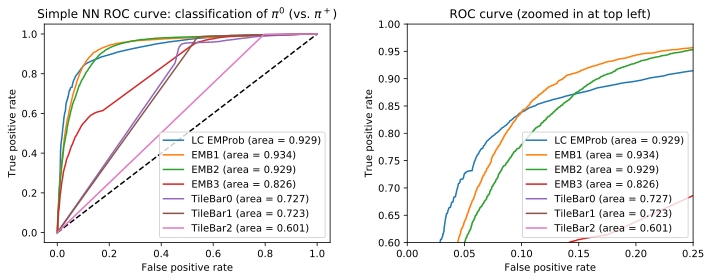

In [15]:
plt.cla(); plt.clf()
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
fig.patch.set_facecolor('white')

ax[0].plot([0, 1], [0, 1], 'k--')
ax[0].plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    ax[0].plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('Simple NN ROC curve: classification of $\pi^0$ (vs. $\pi^+$)')
ax[0].legend(loc='best')

# Zoom in view of the upper left corner.
ax[1].set_xlim(0, 0.25)
ax[1].set_ylim(0.6, 1)
ax[1].plot([0, 1], [0, 1], 'k--')
ax[1].plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    ax[1].plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
# ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title('ROC curve (zoomed in at top left)')
ax[1].legend(loc='best')

plt.show()

In [16]:
# print y_flat_pred[0][:,1]
# print y_flat_pred[1][:,1]
y_flat_pred_stack = np.column_stack((y_flat_pred[0][:,1], y_flat_pred[1][:,1],y_flat_pred[2][:,1],y_flat_pred[3][:,1],y_flat_pred[4][:,1],y_flat_pred[5][:,1]))
print y_flat_pred_stack



[[0.89948404 0.21911909 0.9814817  0.8970459  0.4124996  0.46445063]
 [0.13144894 0.18237664 0.51375467 0.35850382 0.3634654  0.46445063]
 [0.94305754 0.9709976  0.51375467 0.35850382 0.954296   0.46445063]
 ...
 [0.5335133  0.9969957  0.1389513  0.35850382 0.3634654  0.46445063]
 [0.94305754 0.9709976  0.72358894 0.9126935  0.9954823  1.        ]
 [0.13975799 0.8686113  0.16308577 0.35850382 0.36346543 0.46445063]]


In [20]:
model_simpleCombine = Sequential()
model_simpleCombine.add(Dense(6, input_dim=6, kernel_initializer='normal', activation='relu'))
model_simpleCombine.add(Dense(4, activation='relu'))
model_simpleCombine.add(Dense(2, kernel_initializer='normal', activation='softmax'))
model_simpleCombine.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model_simpleCombine.fit(y_flat_pred_stack, y_flat_te_onehot[0], epochs = 120, batch_size = 200, verbose = 2)

Epoch 1/120
 - 1s - loss: 0.6655 - acc: 0.6555
Epoch 2/120
 - 0s - loss: 0.5325 - acc: 0.8245
Epoch 3/120
 - 0s - loss: 0.4147 - acc: 0.8919
Epoch 4/120
 - 0s - loss: 0.3605 - acc: 0.9041
Epoch 5/120
 - 0s - loss: 0.3317 - acc: 0.9086
Epoch 6/120
 - 0s - loss: 0.3135 - acc: 0.9087
Epoch 7/120
 - 0s - loss: 0.3007 - acc: 0.9100
Epoch 8/120
 - 0s - loss: 0.2918 - acc: 0.9109
Epoch 9/120
 - 0s - loss: 0.2848 - acc: 0.9110
Epoch 10/120
 - 0s - loss: 0.2795 - acc: 0.9104
Epoch 11/120
 - 0s - loss: 0.2752 - acc: 0.9109
Epoch 12/120
 - 0s - loss: 0.2718 - acc: 0.9109
Epoch 13/120
 - 0s - loss: 0.2692 - acc: 0.9113
Epoch 14/120
 - 0s - loss: 0.2666 - acc: 0.9108
Epoch 15/120
 - 0s - loss: 0.2648 - acc: 0.9111
Epoch 16/120
 - 0s - loss: 0.2632 - acc: 0.9111
Epoch 17/120
 - 0s - loss: 0.2617 - acc: 0.9112
Epoch 18/120
 - 0s - loss: 0.2605 - acc: 0.9118
Epoch 19/120
 - 0s - loss: 0.2593 - acc: 0.9112
Epoch 20/120
 - 0s - loss: 0.2583 - acc: 0.9119
Epoch 21/120
 - 0s - loss: 0.2577 - acc: 0.9113
E

In [21]:
# this is overtraining, do the smarter thing
combined_pred = model_simpleCombine.predict(y_flat_pred_stack)
fpr_simpleCombine, tpr_simpleCombine, thres_simpleCombine = roc_curve(y_flat_te_onehot[layer_i][:,0], combined_pred[:,0])
auc_combined  = auc(fpr_simpleCombine, tpr_simpleCombine)
print auc_combined

0.9586749364821461


<Figure size 432x288 with 0 Axes>

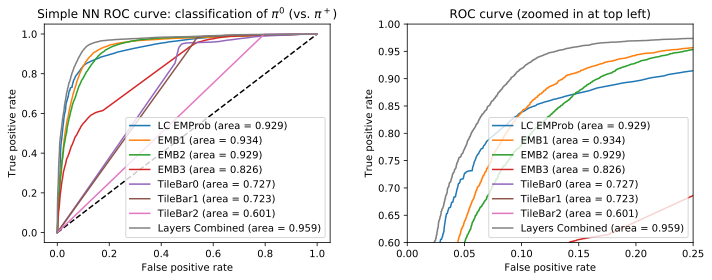

In [24]:
plt.cla(); plt.clf()
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
fig.patch.set_facecolor('white')

ax[0].plot([0, 1], [0, 1], 'k--')
ax[0].plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    ax[0].plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
ax[0].plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers Combined", auc_combined))
ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('Simple NN ROC curve: classification of $\pi^0$ (vs. $\pi^+$)')
ax[0].legend(loc='best')

# Zoom in view of the upper left corner.
ax[1].set_xlim(0, 0.25)
ax[1].set_ylim(0.6, 1)
ax[1].plot([0, 1], [0, 1], 'k--')
ax[1].plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    ax[1].plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
ax[1].plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers Combined", auc_combined))
# ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title('ROC curve (zoomed in at top left)')
ax[1].legend(loc='best')

plt.show()

In [26]:

from keras.models import Model
from keras.layers import concatenate
from keras.layers import Input
from keras.layers import Dense

In [28]:
model_combine = Sequential()

#EMB1
input1 = Input(shape=(512,), name = 'input1')
x1 = Dense(512, activation='relu')(input1)
x1 = Dense(256, activation='relu')(x1)
x1 = Dense(128, activation='relu')(x1)

input2 = Input(shape=(256,), name = 'input2')
x2 = Dense(256, activation='relu')(input2)
x2 = Dense(128, activation='relu')(x2)
x2 = Dense(64, activation='relu')(x2)

input3 = Input(shape=(128,), name = 'input3')
x3 = Dense(128, activation='relu')(input3)
x3 = Dense(64, activation='relu')(x3)
x3 = Dense(32, activation='relu')(x3)

input4 = Input(shape=(16,), name = 'input4')
x4 = Dense(16, activation='relu')(input4)
x4 = Dense(8, activation='relu')(x4)
x4 = Dense(4, activation='relu')(x4)

input5 = Input(shape=(16,), name = 'input5')
x5 = Dense(16, activation='relu')(input5)
x5 = Dense(8, activation='relu')(x5)
x5 = Dense(4, activation='relu')(x5)

input6 = Input(shape=(8,), name = 'input6')
x6 = Dense(8, activation='relu')(input6)
x6 = Dense(4, activation='relu')(x6)
x6 = Dense(2, activation='relu')(x6)

x = concatenate([x1, x2, x3, x4, x5, x6]) 
x = Dense(100, activation='relu')(x)   

output_combine = Dense(2, activation='softmax')(x)

model_combine = Model(inputs = [input1, input2, input3, input4, input5, input6], outputs = [output_combine])
model_combine.compile(loss='categorical_crossentropy', optimizer=Adam(lr=5e-5), metrics=['accuracy'])   

In [29]:
model_combine.fit([x_flat_tr[0], x_flat_tr[1], x_flat_tr[2], x_flat_tr[3], x_flat_tr[4], x_flat_tr[5]], [y_flat_tr_onehot[0]], validation_data=([x_flat_vl[0], x_flat_vl[1], x_flat_vl[2], x_flat_vl[3], x_flat_vl[4], x_flat_vl[5]], [y_flat_vl_onehot[0]]), epochs=80, batch_size=200, verbose=2)

Train on 75000 samples, validate on 5000 samples
Epoch 1/80
 - 17s - loss: 0.5252 - acc: 0.8081 - val_loss: 0.3798 - val_acc: 0.8608
Epoch 2/80
 - 15s - loss: 0.3766 - acc: 0.8600 - val_loss: 0.3573 - val_acc: 0.8668
Epoch 3/80
 - 15s - loss: 0.3603 - acc: 0.8656 - val_loss: 0.3432 - val_acc: 0.8728
Epoch 4/80
 - 15s - loss: 0.3463 - acc: 0.8694 - val_loss: 0.3310 - val_acc: 0.8758
Epoch 5/80
 - 14s - loss: 0.3322 - acc: 0.8723 - val_loss: 0.3201 - val_acc: 0.8778
Epoch 6/80
 - 13s - loss: 0.3214 - acc: 0.8749 - val_loss: 0.3113 - val_acc: 0.8822
Epoch 7/80
 - 15s - loss: 0.3134 - acc: 0.8814 - val_loss: 0.3044 - val_acc: 0.8892
Epoch 8/80
 - 16s - loss: 0.3073 - acc: 0.8853 - val_loss: 0.3010 - val_acc: 0.8898
Epoch 9/80
 - 17s - loss: 0.3010 - acc: 0.8890 - val_loss: 0.2945 - val_acc: 0.8962
Epoch 10/80
 - 19s - loss: 0.2958 - acc: 0.8915 - val_loss: 0.2894 - val_acc: 0.8990
Epoch 11/80
 - 19s - loss: 0.2906 - acc: 0.8938 - val_loss: 0.2857 - val_acc: 0.8998
Epoch 12/80
 - 18s - loss

In [31]:
y_combine_pred = model_combine.predict([x_flat_te[0], x_flat_te[1], x_flat_te[2], x_flat_te[3], x_flat_te[4], x_flat_te[5]])
fpr_combine, tpr_combine, thres_combine = roc_curve(y_flat_te_onehot[layer_i][:,0], y_combine_pred[:,0])
auc_combine = auc(fpr_combine, tpr_combine)
print("Area under curve: {}".format(auc_combine))

Area under curve: 0.962828389264


<Figure size 432x288 with 0 Axes>

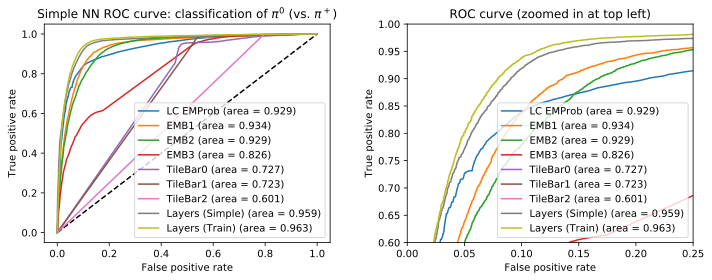

In [33]:
plt.cla(); plt.clf()
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
fig.patch.set_facecolor('white')

ax[0].plot([0, 1], [0, 1], 'k--')
ax[0].plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    ax[0].plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
ax[0].plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
ax[0].plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Train)", auc_combine))
ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('Simple NN ROC curve: classification of $\pi^0$ (vs. $\pi^+$)')
ax[0].legend(loc='best')

# Zoom in view of the upper left corner.
ax[1].set_xlim(0, 0.25)
ax[1].set_ylim(0.6, 1)
ax[1].plot([0, 1], [0, 1], 'k--')
ax[1].plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    ax[1].plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
ax[1].plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
ax[1].plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Train)", auc_combine))
# ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title('ROC curve (zoomed in at top left)')
ax[1].legend(loc='best')

plt.show()

## 2. Convolutional Neural Network

In [ ]:
def format_cnn(data_0, data_1, selected_layer, len_phi = len_phi, len_eta = len_eta):
    layer = layers[selected_layer]
    num_pixels = int(len_phi[selected_layer]*len_eta[selected_layer])
#     print num_pixels
    X = np.append(data_0[layer], data_1[layer], axis=0)
    # reshape to be [samples][width][height][pixels]
#     print X.shape[0]
#     print X
    X = X.reshape(X.shape[0], len_phi[selected_layer], len_eta[selected_layer])
    
    Y = np.append(data_0['label'], data_1['label'], axis=0)

#     print (X.shape)
#     print (y.shape)
    return X, Y, num_pixels

In [ ]:

#old, one by one method
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# Train on pT = 100 GeV electron/pion samples
# mswiatlo-- let's do this with the pi+/pi0 samples!

# include the EMB2 layer as a 2D image
selected_layer = 1
layer = layers[selected_layer]
num_pixels = int(len_phi[selected_layer]*len_eta[selected_layer])

# X = np.append(elec[layer], pion[layer], axis=0)
X = np.append(pp[layer], p0[layer], axis=0)
# reshape to be [samples][width][height][pixels]
#X = X.reshape(X.shape[0], 1, 128, 4)
X = X.reshape(X.shape[0], 1, 16, 16)

# y = np.append(elec['label'], pion['label'], axis=0)
y = np.append(pp['label'], p0['label'], axis=0)

# split up into training and test datasets
test_size = 4000
validation_size = 1000
from sklearn.model_selection import train_test_split
X_tr, X_te_vl, y_tr, y_te_vl, = train_test_split(X, y, test_size=test_size+validation_size, random_state=1)
X_te, X_vl, y_te, y_vl, = train_test_split(X_te_vl, y_te_vl, test_size=validation_size, random_state=1)

# normalize inputs from 0-255 to 0-1
X_tr = X_tr / 255
X_te = X_te / 255
X_vl = X_vl / 255

print (X_tr.shape)
print (y_tr.shape)

# one hot encode outputs
from keras.utils import np_utils
y_tr_onehot = np_utils.to_categorical(y_tr, 2)
y_te_onehot = np_utils.to_categorical(y_te, 2)
y_vl_onehot = np_utils.to_categorical(y_vl, 2)
num_classes = y_te_onehot.shape[1]
print("y_train.shape: ",y_tr.shape)
print("y_train_onehot.shape: ",y_tr_onehot.shape)

In [ ]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

x_cnn = {}
y_cnn = {}
num_pixels_cnn = {}
for layer_i, layer_name in enumerate(layers):
    x_cnn[layer_i], y_cnn[layer_i], num_pixels_cnn[layer_i] = format_cnn(p0, pp, layer_i)
    
# print x_cnn[0]

In [ ]:
# split up into training and test datasets, using functions
test_size = 4000
validation_size = 1000

x_cnn_tr = {}
x_cnn_te = {}
x_cnn_vl = {}
y_cnn_tr_onehot = {}
y_cnn_te_onehot = {}
y_cnn_vl_onehot = {}
for layer_i, layer_name in enumerate(layers):
    x_cnn_tr[layer_i], x_cnn_te[layer_i], x_cnn_vl[layer_i], y_cnn_tr_onehot[layer_i], y_cnn_te_onehot[layer_i], y_cnn_vl_onehot[layer_i] = make_split_samples(x_flat[layer_i], y_flat[layer_i], test_size, validation_size)


In [ ]:
# define a simple convolutional model
def baseline_ccn_model(layer, len_phi = len_phi, len_eta = len_eta):
    # create model
    model = Sequential()
    model.add(Conv2D(32, (4, 4), input_shape=(1,len_phi[layer],len_eta[layer]), activation='relu'))
    if layer > 0 and layer < 3:
        model.add(MaxPooling2D(pool_size=(2, 2)))
    elif layer == 0:
        model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# build the model
model_cnn_base = {}
for layer_i, layer_name in enumerate(layers):
    print layer_name, layer_i, len_phi[layer_i], len_eta[layer_i]
    if layer_i == 5:
        break # don't bother with tilebar2, too ungranular for our setup right now
    model_cnn_base[layer_i] = baseline_ccn_model(layer_i)
    model_cnn_base[layer_i].summary()

In [ ]:
# define a deep-ish convolutional model
def larger_cnn_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (4, 4), input_shape=(1,16,16), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# build the model
model_cnn_large = larger_cnn_model()
model_cnn_large.summary()

In [ ]:
history_cnn_base = {}
for layer_i, layer_name in enumerate(layers):
    if layer_i == 5:
        break; # skipping 5 right now
    history_cnn_base[layer_i] = model_cnn_base[layer_i].fit(x_cnn_tr[layer_i], y_cnn_tr_onehot[layer_i], validation_data=(x_cnn_vl[layer_i], y_cnn_vl_onehot[layer_i]), epochs=20, batch_size=200, verbose=2)


In [ ]:
# fit (train) the baseline cnn model
history_cnn_base = model_cnn_base.fit(X_tr, y_tr_onehot, validation_data=(X_vl, y_vl_onehot), epochs=20, batch_size=200, verbose=2)

# final evaluation of the model
scores_cnn_base = model_cnn_base.evaluate(X_te, y_te_onehot, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores_cnn_base[1]*100))

In [ ]:
# fit (train) the larger cnn model
history_cnn_large = model_cnn_large.fit(X_tr, y_tr_onehot, validation_data=(X_vl, y_vl_onehot), epochs=20, batch_size=200, verbose=2)

# final evaluation of the model
scores_cnn_large = model_cnn_large.evaluate(X_te, y_te_onehot, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores_cnn_large[1]*100))

In [ ]:
# Plot accuracy and loss vs. epoch

# list all data in history
print(history_cnn_large.history.keys())
fig = plt.figure()
fig.patch.set_facecolor('white')

# summarize history for accuracy
plt.plot(history_cnn_large.history['acc'])
plt.plot(history_cnn_large.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_cnn_large.history['loss'])
plt.plot(history_cnn_large.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 3. Train multiple ConvNets on the images and merge

Next, try to train convolutional nets on multiple input layers, then merge and flatten the layers.

In [ ]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# Train on pT = 100 GeV electron/pion samples
# Mswiatlo-- let's do it on pi+ vs pi0

# This will allow it to be images, instead of flatenned, in emb1
# X0 = np.append(pp['EMB1'], p0['EMB1'], axis=0)

# flatten first layer (for now...) 
X0 = np.append(pp['EMB1'].reshape((len(pp['EMB1']),512)),
              p0['EMB1'].reshape((len(p0['EMB1']),512)), axis=0)

X1 = np.append(pp['EMB2'], p0['EMB2'], axis=0)
X2 = np.append(pp['EMB3'], p0['EMB3'], axis=0)

# reshape to be [samples][width][height][pixels]
# X0 = X0.reshape(X0.shape[0], 1, 128, 4) #uncomment for images mode
X1 = X1.reshape(X1.shape[0], 1, 16, 16)
X2 = X2.reshape(X2.shape[0], 1, 8, 16)

y = np.append(pp['label'], p0['label'], axis=0)

print X0.shape
print X1.shape
print X2.shape
print y.shape

# split up into training and test datasets
# test_size = 4000
# validation_size = 1000
test_size = 8000 # double this, mswiatlo
validation_size = 2000 #double this, mswiatlo
from sklearn.model_selection import train_test_split
X0_tr, X0_te_vl, X1_tr, X1_te_vl, X2_tr, X2_te_vl, y_tr, y_te_vl, = train_test_split(X0, X1, X2, y, test_size=test_size+validation_size, random_state=1)
X0_te, X0_vl, X1_te, X1_vl, X2_te, X2_vl, y_te, y_vl, = train_test_split(X0_te_vl, X1_te_vl, X2_te_vl, y_te_vl, test_size=validation_size, random_state=1)

# normalize inputs from 0-255 to 0-1
X0_tr = X0_tr / 255
X0_te = X0_te / 255
X0_vl = X0_vl / 255
X1_tr = X1_tr / 255
X1_te = X1_te / 255
X1_vl = X1_vl / 255
X2_tr = X2_tr / 255
X2_te = X2_te / 255
X2_vl = X2_vl / 255

print (X0_tr.shape)
print (y_tr.shape)

# one hot encode outputs
from keras.utils import np_utils
y_tr_onehot = np_utils.to_categorical(y_tr, 2)
y_te_onehot = np_utils.to_categorical(y_te, 2)
y_vl_onehot = np_utils.to_categorical(y_vl, 2)
num_classes = y_te_onehot.shape[1]
print("y_train.shape: ",y_tr.shape)
print("y_train_onehot.shape: ",y_tr_onehot.shape)

In [ ]:
# define convolutional model for multiple input images

from keras.models import Model
from keras.layers import concatenate
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

In [ ]:
# create model

def merged_model_emb12():
    
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(512,), name='input1')
    x1 = Dense(512, activation='relu')(input1)
    x1 = Dense(256, activation='relu')(x1) 
    x1 = Dense(128, activation='relu')(x1) 

    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu')(input2)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)

    # concatenate outputs from the two networks above
    x = concatenate([x1, x2]) 
    x = Dense(50, activation='relu')(x)    

    # final output
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs = [input1, input2], outputs = [output])
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model

In [ ]:
# build the model
model_merged_emb12 = merged_model_emb12()
model_merged_emb12.summary()

In [ ]:
# fit (train) the merged model
history = model_merged_emb12.fit([X0_tr, X1_tr], [y_tr_onehot], validation_data=([X0_vl, X1_vl], [y_vl_onehot]), epochs=80, batch_size=200, verbose=2)

# final evaluation of the model
scores = model_merged_emb12.evaluate([X0_te, X1_te], [y_te_onehot], verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

In [ ]:
# Plot accuracy and loss vs. epoch

# list all data in history
print(history.history.keys())

plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#plt.savefig('merged_cnn_accuracy.pdf')

# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()
#plt.savefig('merged_cnn_loss.pdf')

In [ ]:
# plot ROC curve
from sklearn.metrics import roc_curve, auc
y_pred = model_merged_emb12.predict([X0_te, X1_te])
fpr_merge_emb12, tpr_merge_emb12, thres_merge = roc_curve(y_te_onehot[:,0], y_pred[:,0])
auc_merge = auc(fpr_merge_emb12, tpr_merge_emb12)
print("Area under curve: {}".format(auc_merge))

In [ ]:
plt.cla(); plt.clf()
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
fig.patch.set_facecolor('white')
ax[0].plot([0, 1], [0, 1], 'k--')
ax[0].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[0].plot(fpr_merge_emb12, tpr_merge_emb12, label='Merged EMB1f + EMB2ConvNet (area = {:.3f})'.format(auc_merge))
ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('ROC curve: classification of pi0 (vs. charged pions)')
ax[0].legend(loc='best')

# Zoom in view of the upper left corner.
ax[1].set_xlim(0, 0.2)
ax[1].set_ylim(0.8, 1)
ax[1].plot([0, 1], [0, 1], 'k--')
ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[1].plot(fpr_merge_emb12, tpr_merge_emb12, label='Merged EMB1f + EMB2 ConvNet (area = {:.3f})'.format(auc_merge))
ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title('ROC curve (zoomed in at top left)')
ax[1].legend(loc='best')

plt.show()
#plt.savefig('ROC_curve_final.pdf')

Next: Include all input images (calorimeter layers)

Visualize the filters: 
 https://hackernoon.com/visualizing-parts-of-convolutional-neural-networks-using-keras-and-cats-5cc01b214e59

In [ ]:
# create model

def merged_model_emb123():
    
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(512,), name='input1')
    x1 = Dense(512, activation='relu')(input1)
    x1 = Dense(256, activation='relu')(x1) 
    x1 = Dense(128, activation='relu')(x1) 

    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu')(input2)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)
    
    # EMB3 image (convolutional)
    input3 = Input(shape=(1,8,16), name='input3')
    x3 = Conv2D(32, (2, 4), activation='relu')(input3)
    x3 = MaxPooling2D(pool_size=(1, 2))(x3)
    x3 = Dropout(0.2)(x3)
    x3 = Flatten()(x3)
    x3 = Dense(128, activation='relu')(x3)

    # concatenate outputs from the three networks above
    x = concatenate([x1, x2, x3]) 
    x = Dense(50, activation='relu')(x)    

    # final output
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs = [input1, input2, input3], outputs = [output])
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model

In [ ]:
model_merged_emb123 = merged_model_emb123()
model_merged_emb123.summary()

In [ ]:
# fit (train) the merged model
history_emb123 = model_merged_emb123.fit([X0_tr, X1_tr, X2_tr], [y_tr_onehot], validation_data=([X0_vl, X1_vl, X2_vl], [y_vl_onehot]), epochs=80, batch_size=200, verbose=2)

# final evaluation of the model
scores_emb123 = model_merged_emb123.evaluate([X0_te, X1_te, X2_te], [y_te_onehot], verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

In [ ]:
# plot ROC curve
from sklearn.metrics import roc_curve, auc
y_pred = model_merged_emb123.predict([X0_te, X1_te, X2_te])
fpr_merge_emb123, tpr_merge_emb123, thres_merge = roc_curve(y_te_onehot[:,0], y_pred[:,0])
auc_merge_emb123 = auc(fpr_merge_emb123, tpr_merge_emb123)
print("Area under curve: {}".format(auc_merge_emb123))

In [ ]:
plt.cla(); plt.clf()
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
fig.patch.set_facecolor('white')
ax[0].plot([0, 1], [0, 1], 'k--')
ax[0].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[0].plot(fpr_merge_emb12, tpr_merge_emb12, label='Merged EMB1f + EMB2ConvNet (area = {:.3f})'.format(auc_merge))
ax[0].plot(fpr_merge_emb123, tpr_merge_emb123, label='Merged EMB1f + EMB2ConvNet +EMB3ConvNet (area = {:.3f})'.format(auc_merge_emb123))
ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('ROC curve: classification of pi0 (vs. charged pions)')
ax[0].legend(loc='best')

# Zoom in view of the upper left corner.
ax[1].set_xlim(0, 0.2)
ax[1].set_ylim(0.8, 1)
ax[1].plot([0, 1], [0, 1], 'k--')
ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[1].plot(fpr_merge_emb12, tpr_merge_emb12, label='Merged EMB1f + EMB2 ConvNet (area = {:.3f})'.format(auc_merge))
ax[1].plot(fpr_merge_emb123, tpr_merge_emb123, label='Merged EMB1f + EMB2ConvNet +EMB3ConvNet (area = {:.3f})'.format(auc_merge_emb123))
ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title('ROC curve (zoomed in at top left)')
ax[1].legend(loc='best')

plt.show()
#plt.savefig('ROC_curve_final.pdf')